### Collect the price of a company over the specific period

In [1]:
# collect price of samsung electronics


# price sources from naver finance
# 1 https://fchart.stock.naver.com/sise.nhn?symbol=005930&timeframe=day&count=1500&requestType=0
# 2  https://api.finance.naver.com/siseJson.naver?symbol=005930&requestType=1&startTime=20210214&endTime=20210726&timeframe=day




In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import re
import io
from scraper import get_ticker


In [3]:
def parse_number(string, type):
    try:
        number = type(re.search('[\d.]+', string)[0])
        return number
    except Exception as e:
        print("error occurred in parse_number: ", e)
        return string

In [4]:
def get_price_history(company_name):
    ''' 
    given company name, return pd.DataFrame composed of stock price history
    column='종가', index='날짜'
    '''

    # url for getting price history
    ticker = get_ticker(company_name)
    today = datetime.datetime.today()
    five_yrs_ago = datetime.datetime.today() - relativedelta(years=5)
    startTime = five_yrs_ago.strftime('%Y%m%d')
    endTime = today.strftime('%Y%m%d')   #YYYYMMDD
    timeframe = 'day'
    url = 'https://api.finance.naver.com/siseJson.naver?symbol='+ticker+'&requestType=1&startTime='+startTime+'&endTime='+endTime+'&timeframe='+timeframe

    # get data from url
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')

    # convert string into a pandas dataframe using pd.read_csv
    data_string = io.StringIO(soup.text)
    df = pd.read_csv(data_string)

    # Data Cleansing

    # drop rows and columns with NaN
    df = df.dropna(thresh = 3,axis=1)
    df = df.dropna(thresh = 3, axis=0)

    # clean column names (remove trash char)
    for _column in df.columns:
        df = df.rename(columns={_column: _column.replace('[','').replace(']','').replace("'","").replace(' ','')})    

    # clean '날짜' column
    for index,_ in enumerate(df['날짜']):
        _dateint = parse_number(str(df.loc[index, '날짜']), int)
        df.loc[index, '날짜'] = datetime.datetime.strptime(f'{_dateint}', '%Y%m%d').date()

    # clean '외국인소진율' column
    for index,_ in enumerate(df['외국인소진율']):
        df.loc[index, '외국인소진율'] = parse_number(str(df.loc[index, '외국인소진율']), float)

    # change data type from float to int
    df[['시가', '고가', '저가', '종가', '거래량']] = df[['시가', '고가', '저가', '종가', '거래량']].astype(int)

    # get only date & closing price column
    df_price = df[['날짜','종가']]
    df_price = df_price.rename(columns={'날짜': 'date', '종가': 'price'})
    df_price = df_price.set_index('date',drop=True)

    return df_price

### Load & Save price data for companies

In [5]:
# set korean font for matploblib
import matplotlib as mat
import matplotlib.pyplot as plt
mat.rcParams['font.family'] = 'Malgun Gothic'

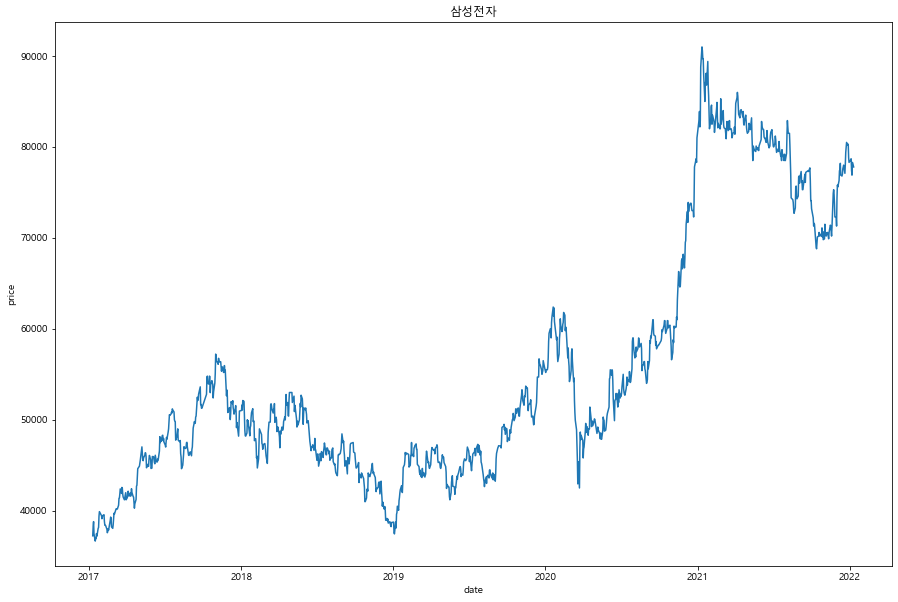

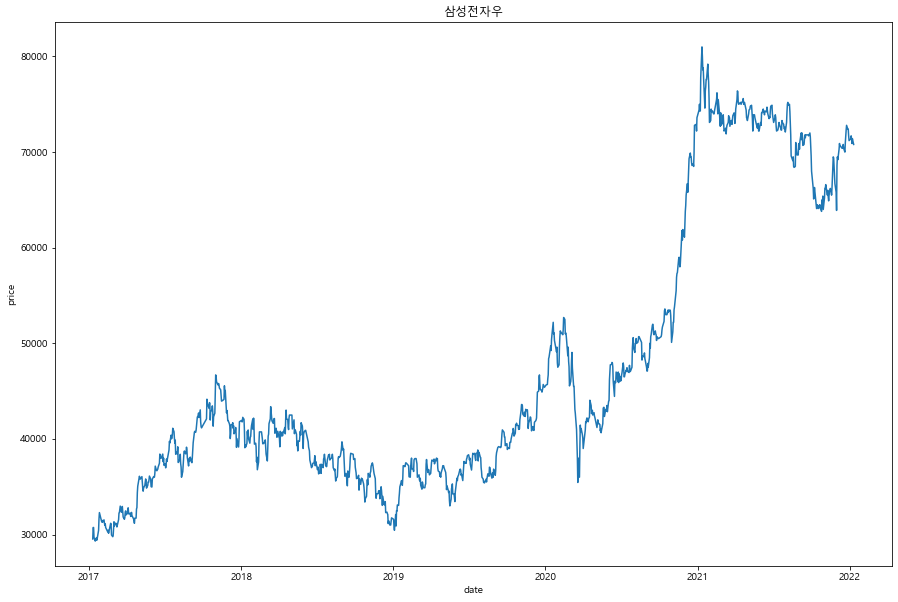

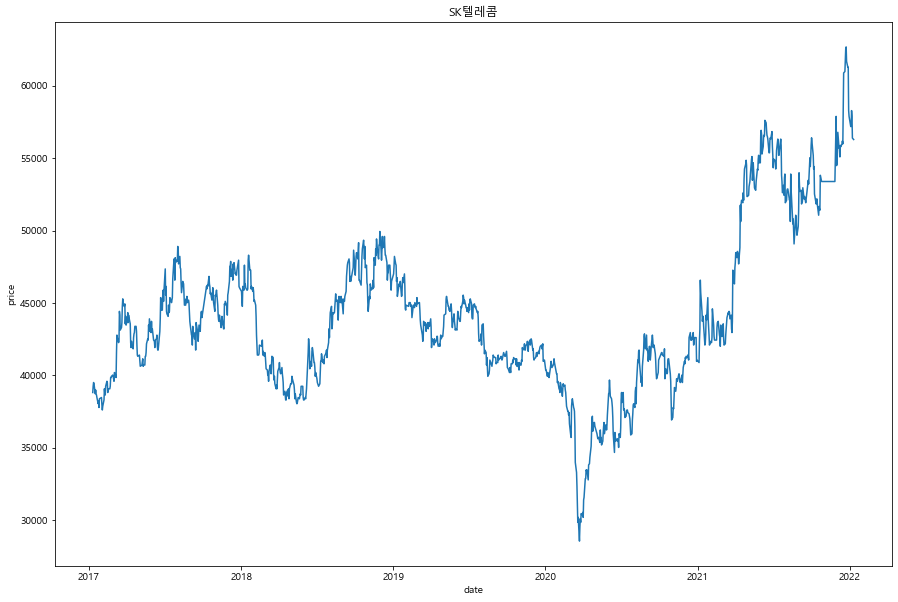

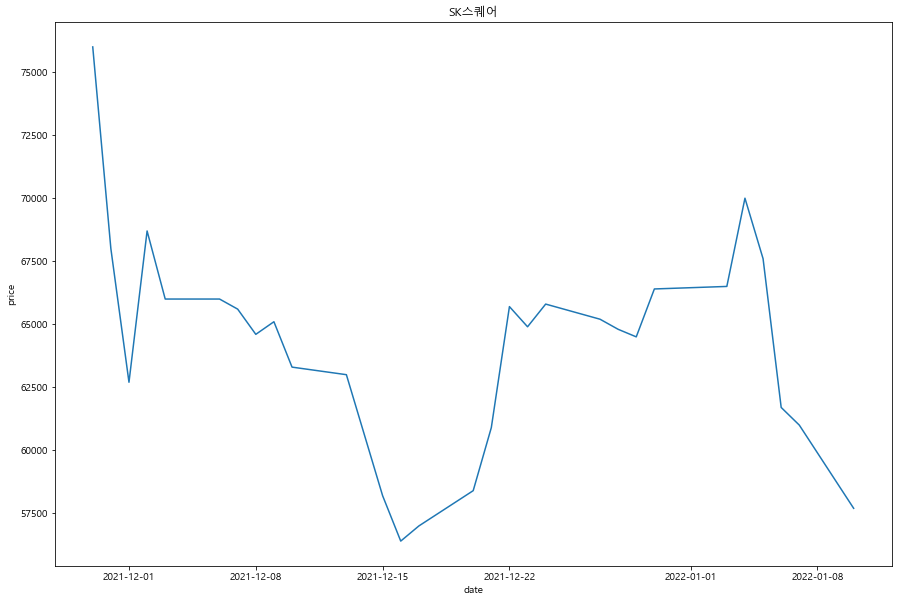

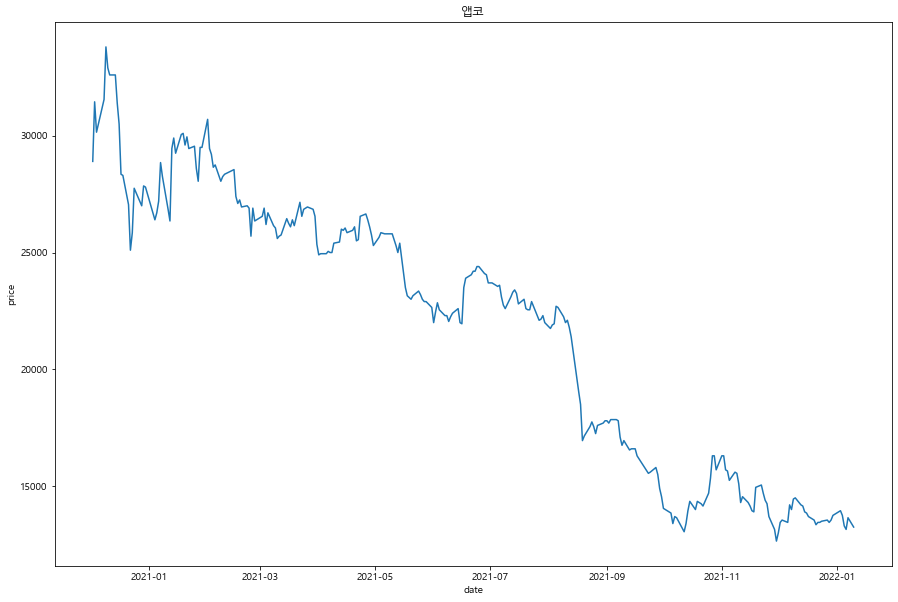

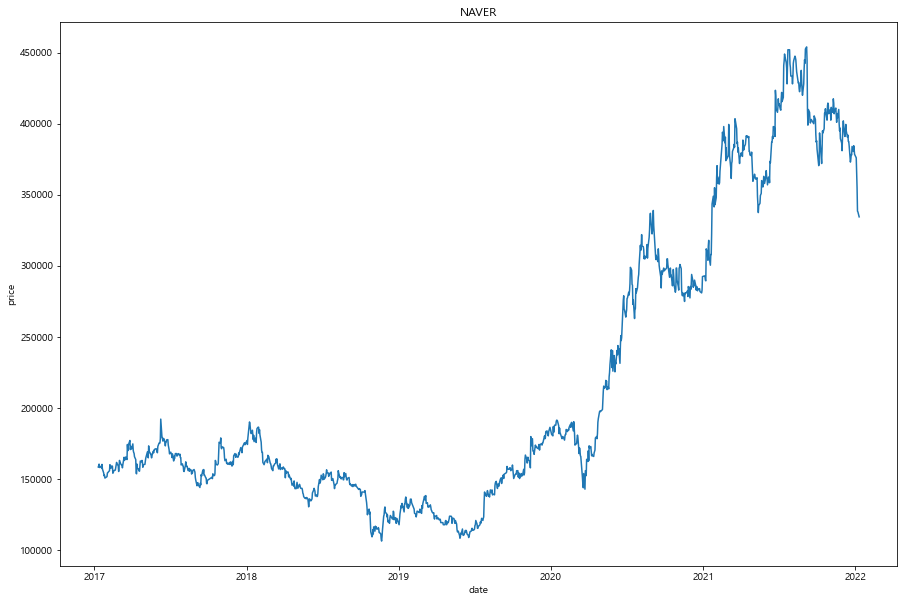

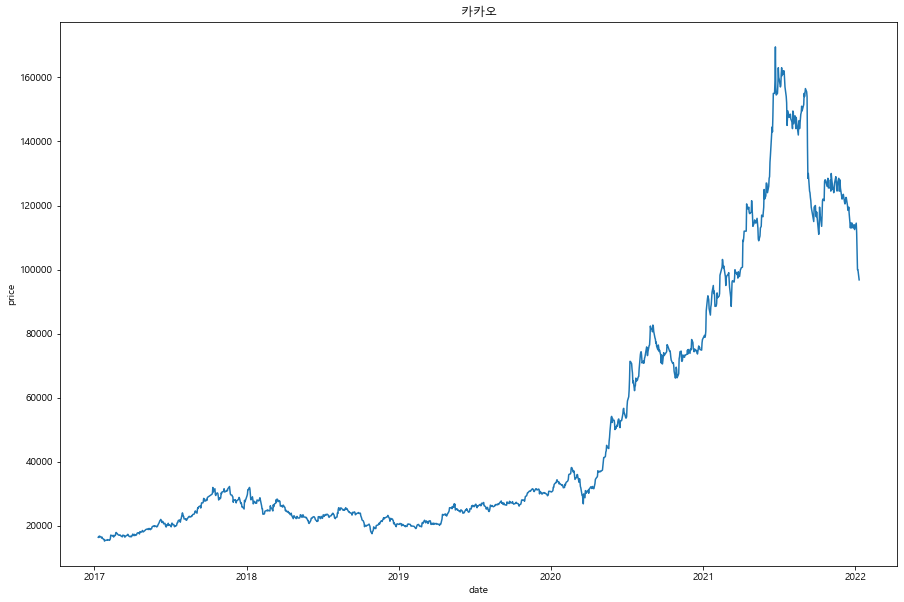

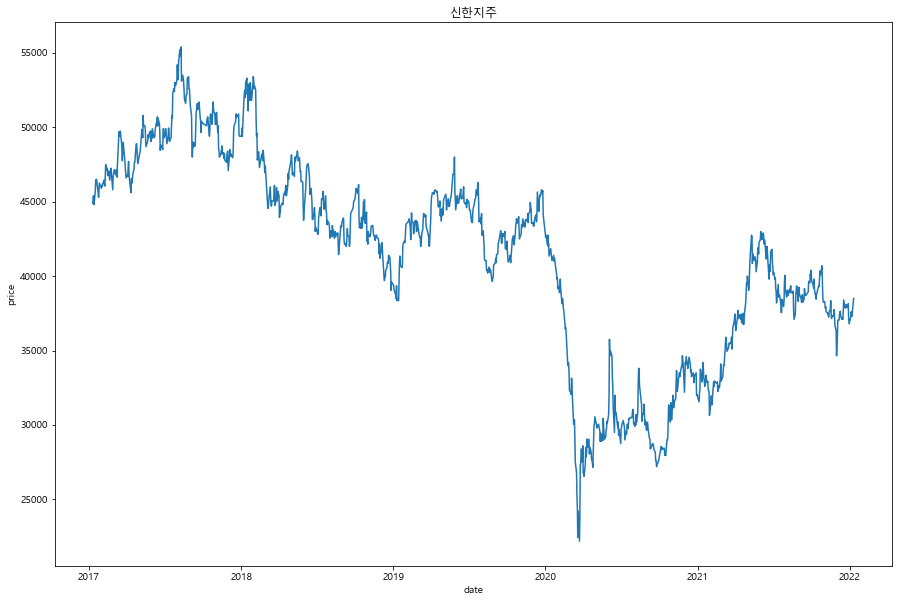

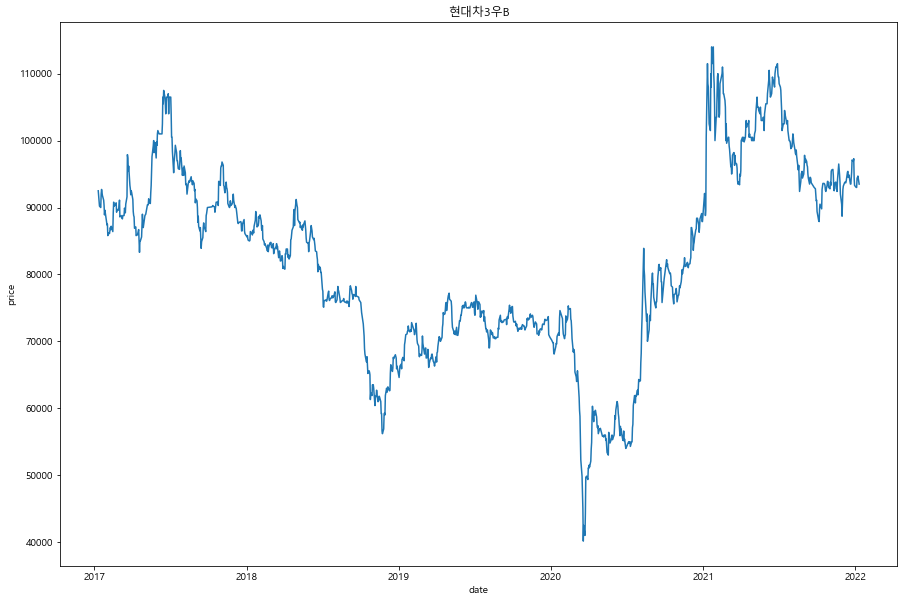

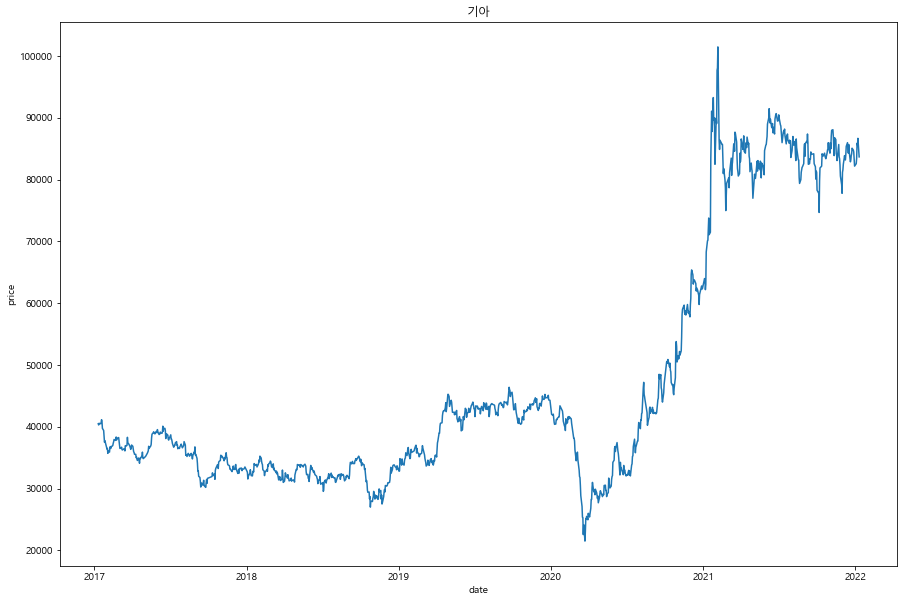

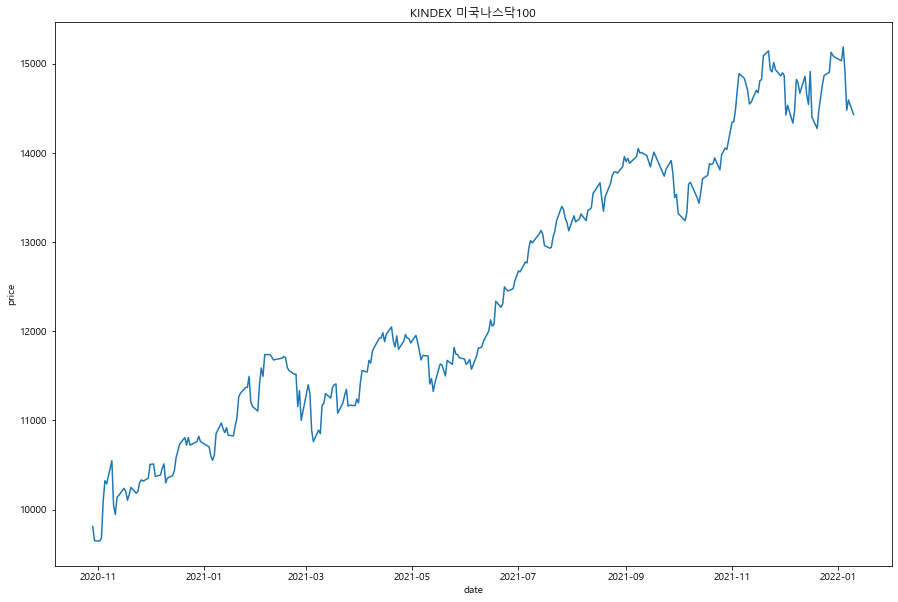

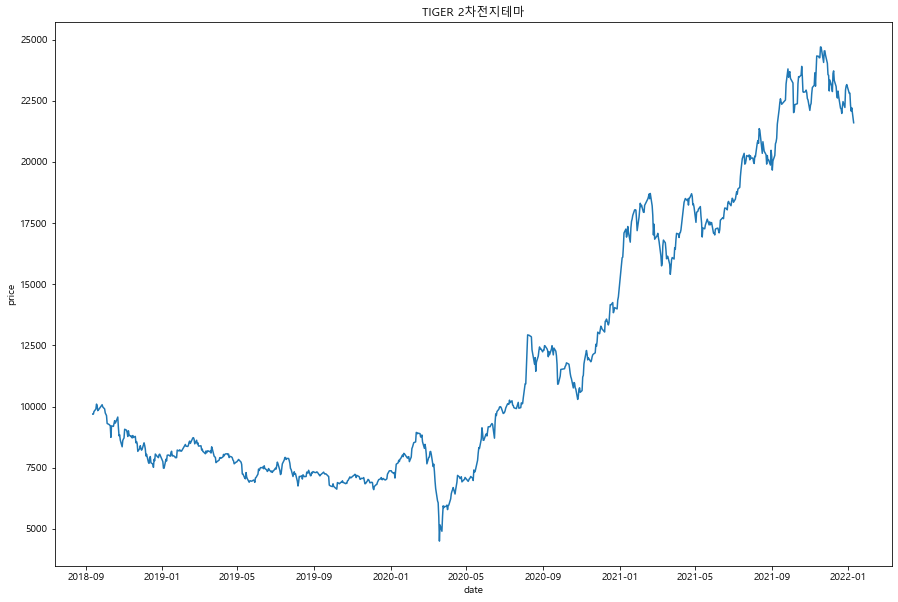

In [17]:
company_list = ['삼성전자', '삼성전자우', 'SK텔레콤', 'SK스퀘어', '앱코', 'NAVER', '카카오', '신한지주', '현대차3우B', '기아', 'KINDEX 미국나스닥100', 'TIGER 2차전지테마']

for company_name in company_list:
    try:
        df_price = get_price_history(company_name)
    except Exception as e:
        print(f"Failed for {company_name}: ", e)
    plt.figure(figsize=(15,10))
    df_price['price'].plot(ylabel='price',title=company_name)
    df_price.to_csv(f'price_history/{company_name}_price.csv')

In [ ]:
df_price.to_csv(f'price_history/{company_name}_price.csv')

In [ ]:
# load price history csv file
# df = pd.read_csv('price_history/삼성전자_price.csv', index_col='날짜')